In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
print(os.listdir("../input"))

['tmp', 'test.csv.zip', 'scalar_coupling_contributions.csv.zip', 'structures.csv.zip', 'potential_energy.csv', 'dipole_moments.csv', 'dipole_moments.csv.zip', 'mulliken_charges.csv.zip', 'test.csv', 'scalar_coupling_contributions.csv', 'structures.csv', 'sample_submission.csv', 'mulliken_charges.csv', 'potential_energy.csv.zip', 'magnetic_shielding_tensors.csv.zip', 'train.csv.zip', 'structures', 'magnetic_shielding_tensors.csv', '.gitkeep', 'train.csv', 'sample_submission.csv.zip']


In [2]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor


In [3]:
%%time

#input_dir = '../work/subsample_50000'
input_dir = '../input'

train = pd.read_csv(input_dir + '/train.csv', index_col='id')
test = pd.read_csv(input_dir + '/test.csv', index_col='id')

/home/edgarpe/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 2.99 s, sys: 285 ms, total: 3.28 s
Wall time: 3.28 s


In [4]:
train.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [5]:
%%time

structures = pd.read_csv('../input/structures.csv')
structures.head()

CPU times: user 1.4 s, sys: 72.1 ms, total: 1.47 s
Wall time: 1.47 s


In [6]:
%%time

# Map the atom structure data into train and test files

def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

CPU times: user 5.19 s, sys: 2.57 s, total: 7.76 s
Wall time: 7.76 s


In [7]:
%%time

# Engineer a single feature: distance vector between atoms
#  (there's ways to speed this up!)

# This block is SPPED UP

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

CPU times: user 164 ms, sys: 82.8 ms, total: 247 ms
Wall time: 244 ms


In [8]:
%%time

molecules = train.pop('molecule_name')
test = test.drop('molecule_name', axis=1)

y = train.pop('scalar_coupling_constant')

# Label Encoding
for f in ['type', 'atom_0', 'atom_1']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

CPU times: user 7.98 s, sys: 684 ms, total: 8.67 s
Wall time: 8.67 s


In [9]:
%%time

yoof = np.zeros(len(train))
yhat = np.zeros(len(test))

n_splits = 3
gkf = GroupKFold(n_splits=n_splits) # we're going to split folds by molecules

fold = 0
for in_index, oof_index in gkf.split(train, y, groups=molecules):
    fold += 1
    print(f'fold {fold} of {n_splits}')
    X_in, X_oof = train.values[in_index], train.values[oof_index]
    y_in, y_oof = y.values[in_index], y.values[oof_index]
    reg = RandomForestRegressor(n_estimators=250,
                                max_depth=9,
                                min_samples_leaf=3,
                                n_jobs=-1)
    reg.fit(X_in, y_in)
    yoof[oof_index] = reg.predict(X_oof)
    yhat += reg.predict(test)

yhat /= n_splits

fold 1 of 3
fold 2 of 3
fold 3 of 3
CPU times: user 4h 54min 2s, sys: 21.9 s, total: 4h 54min 24s
Wall time: 1h 18min 26s


In [10]:
%%time

sample_submission = pd.read_csv(input_dir + '/sample_submission.csv', index_col='id')

benchmark = sample_submission.copy()
benchmark['scalar_coupling_constant'] = yhat
benchmark.to_csv('../work/atomic_distance_benchmark_on_sample.csv')

/home/edgarpe/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 5.37 s, sys: 52 ms, total: 5.42 s
Wall time: 5.4 s


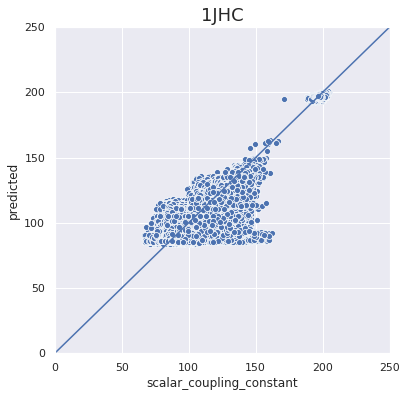

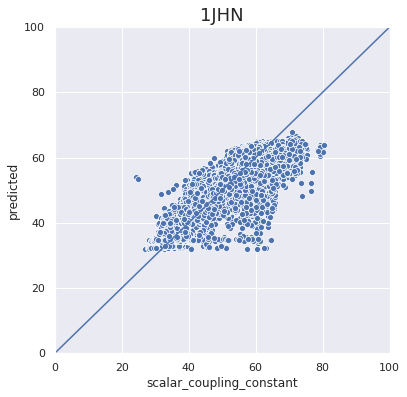

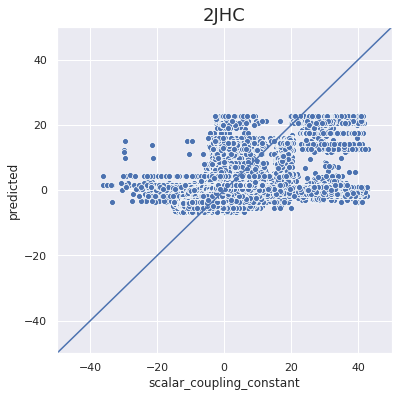

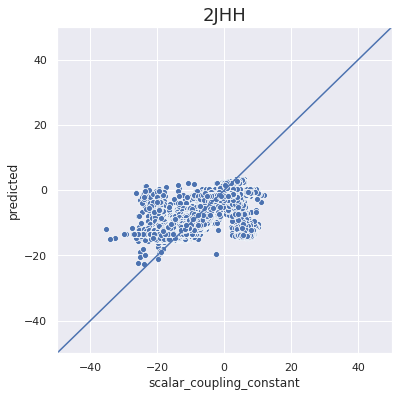

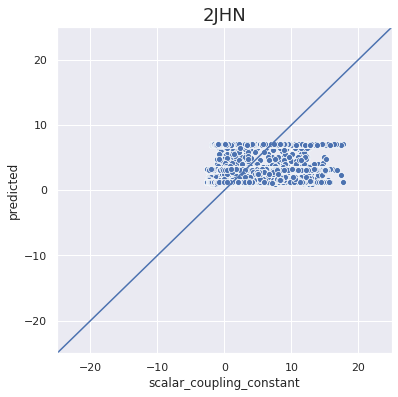

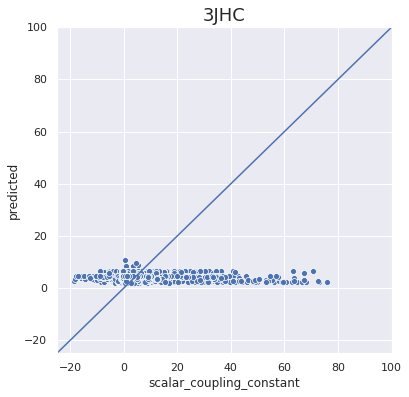

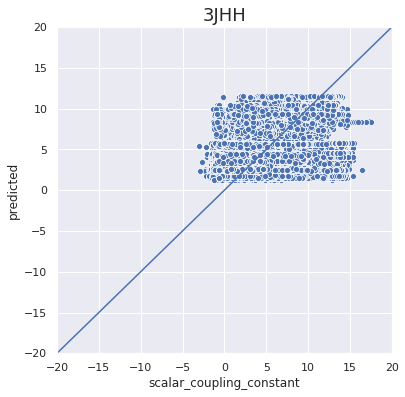

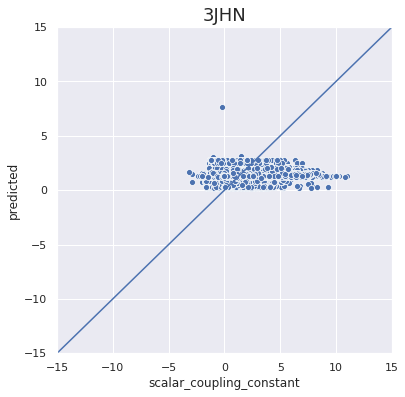

In [11]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = yoof
plot_data['type'] = pd.read_csv(input_dir + '/train.csv', index_col='id', usecols=['id', 'type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)